In [1]:
import pandas as pd
from environment import root_dir
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import itertools
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.usetex'] = True

In [2]:
task_vis_results = pd.read_pickle(f"{root_dir}/results/results-tree-vis-v3.pkl")
generation_results = pd.read_pickle(f"{root_dir}/results/results-generation.pkl")
compare_results = pd.read_pickle(f"{root_dir}/results/results-tree-compare.pkl")

In [3]:
mpl.rcParams.update(mpl.rcParamsDefault)
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
# plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

In [4]:
models = {
    "deepseek-ai/deepseek-reasoner": {
        "label": "DeepSeek-R1", 
        "color": colors[0],
    }, 
    "xai/grok-3-mini-beta": {
        "label": "Grok 3 Mini Beta", 
        "color": colors[1],
    },
    "claude/claude-3-7-sonnet-20250219-thinking": {
        "label": "Claude 3.7 Sonnet", 
        "color": colors[5],
    },
    "openrouter-qwen/qwq-32b": {
        "label": "QwQ-32B", 
        "color": colors[3],
    },  
    "openrouter-microsoft/phi-4-reasoning-plus": {
        "label": "Phi-4-reasoning-plus", 
        "color": colors[4],
    },
}

metrics = {
    "average_forgetting_rate": {
        "label": r'Forgetting Rate ($r_{\mathrm{forget}}$)',
        "concise_label": r'$r_{\mathrm{forget}}$',
        "plain_label": "Forgetting Rate",
    },
    "average_solution_count": {
        "label": r'Solution Count ($\mathrel{\#}_{\mathrm{solution}}$)',
        "concise_label": r'$\mathrel{\#}_{\mathrm{solution}}$',
        "plain_label": "Solution Count",
    },
    "overall_average_verification_rate": {
        "label": r"Verification Rate ($r_{\mathrm{verify}}$)",
        "concise_label": r'$r_{\mathrm{verify}}$',
        "plain_label": "Verification Rate",
    },
    "filtered_ajd": {
        "label": r'Jump Distance ($d_{\mathrm{jump}}$)',
        "concise_label": r'$d_{\mathrm{jump}}$',
        "plain_label": "Jump Distance",
    },
    "average_success_rate": {
        "label": r'Success Rate ($r_{\mathrm{success}}$)',
        "concise_label": r'$r_{\mathrm{success}}$',
        "plain_label": "Success Rate",
    },
    "average_overthinking_rate": {
        "label": r'Overthinking Rate ($r_{\mathrm{overthinking}}$)',
        "concise_label": r'$r_{\mathrm{overthinking}}$',
        "plain_label": "Overthinking Rate",
    },
    "average_correlation": {
        "label": "Pass@1",
        "concise_label": "Pass@1",
        "plain_label": "Pass@1",
    },
}

dataset_metrics = {
    "math500": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_correlation",
    ],
    "game24": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_success_rate",
        "average_overthinking_rate",
        "average_correlation",
    ],
}

final_datasets = {
    'math500': "MATH-500", 
    'game24': "Game of 24",
}
final_metrics = [
    "average_correlation", 
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "average_overthinking_rate",
    "overall_average_verification_rate",
    "average_forgetting_rate",
]

In [5]:
def get_row(df, **kwargs):
    condition = None
    for key, value in kwargs.items():

        if condition is None:
            condition = df[key] == value
        else:
            condition &= df[key] == value
    return df[condition].reset_index(drop=True)

In [6]:
reasoning_metrics = {}
for dataset in final_datasets:
    reasoning_metrics[dataset] = {}
    for model in models:
        
        row = get_row(
            task_vis_results, 
            model_name=model, 
            dataset_name=dataset, 
            temperature=1,
        )
        for metric in final_metrics:
            if metric not in reasoning_metrics[dataset]:
                reasoning_metrics[dataset][metric] = {}
            

            reasoning_metrics[dataset][metric][model] = row.iloc[0][metric]


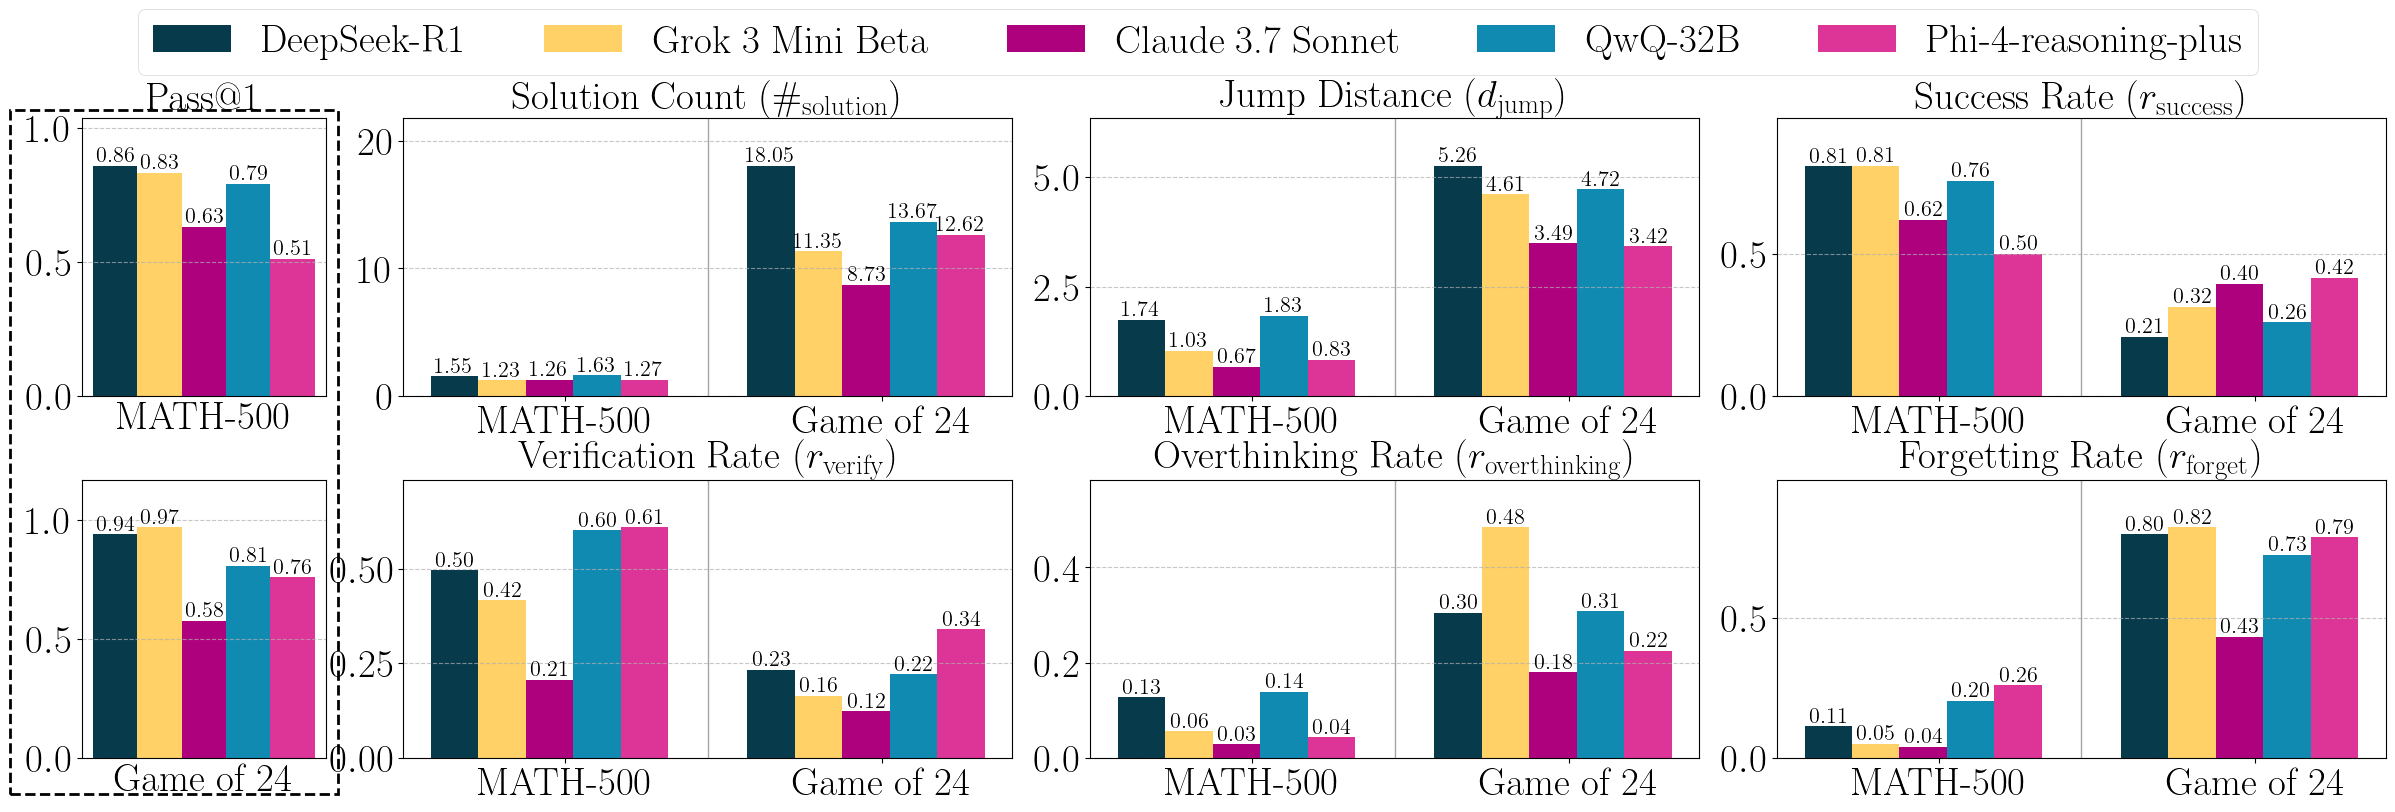

In [7]:
this_metrics = [
    "average_correlation",  # Put average_correlation first
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "overall_average_verification_rate",
    "average_overthinking_rate",
    "average_forgetting_rate",
]

# Create a figure with 2 rows and 4 columns (correlation on left, other metrics on right)
fig, axs = plt.subplots(2, 4, gridspec_kw={'width_ratios': [0.4, 1, 1, 1]})  # Reduced width ratio for correlation column
fig.subplots_adjust(left=0.035, bottom=.05, right=0.995, top=.85, wspace=0.15, hspace=0.3)
fig.set_size_inches(24, 8) 

# Set width of bars
bar_width = 0.15  # For the right side plots with multiple datasets
correlation_bar_width = 0.25  # Wider bars for the correlation plot

# Set positions of the bars on X axis
index = np.arange(len(final_datasets))

# Restructure data for plotting
# First, create a dictionary where metrics are the top level keys
restructured_metrics = {}
for metric in this_metrics[1:]:  # Skip correlation for now
    restructured_metrics[metric] = {}
    for model in models:
        restructured_metrics[metric][model] = []
        for dataset in final_datasets:
            restructured_metrics[metric][model].append(reasoning_metrics[dataset][metric][model])

# Set the title for the correlation column
metric = "average_correlation"
axs[0, 0].set_title(metrics[metric]["label"], fontsize=28)

# Plot the correlation metric separately in the first column
for i, dataset_key in enumerate(final_datasets):
    dataset_name = final_datasets[dataset_key]
    
    # Plot bars for each model
    for j, model in enumerate(models):
        axs[i, 0].bar(j, reasoning_metrics[dataset_key][metric][model], 
                  correlation_bar_width*4, label=models[model]["label"] if i == 0 and j == 0 else "", 
                  color=models[model]["color"])
    
    # Add value labels on top of bars
    for j, model in enumerate(models):
        value = reasoning_metrics[dataset_key][metric][model]
        axs[i, 0].text(j, value, f'{value:.2f}', ha='center', va='bottom', fontsize=16)
    
    # Set xlabel as dataset name instead of title
    axs[i, 0].set_xlabel(dataset_name, fontsize=28)
    axs[i, 0].set_xticks([])
    axs[i, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    current_ylim = axs[i, 0].get_ylim()
    axs[i, 0].set_ylim(0, current_ylim[1] * 1.15)  # Add 15% padding at the top

# Add a dashed box around the correlation subplots
# Get the position of the first column of subplots
pos0 = axs[0, 0].get_position()
pos1 = axs[1, 0].get_position()
# Create a rectangle patch to surround both correlation subplots
rect = plt.Rectangle(
    (pos0.x0 - 0.03, pos1.y0 - 0.045),  # x, y (bottom left corner)
    pos0.width + 0.035,  # width
    pos0.y0 + pos0.height - pos1.y0 + 0.055,  # height
    linewidth=2,
    linestyle='dashed',
    edgecolor='black',
    facecolor='none',
    zorder=1000,
    transform=fig.transFigure
)
fig.add_artist(rect)

# Create the bar plots for the remaining metrics
for i, metric in enumerate(this_metrics[1:]):  # Skip correlation which we already plotted
    row = i // 3
    col = (i % 3) + 1  # +1 because first column is for correlation
    
    for j, model in enumerate(models):
        # Calculate position for each bar within its cluster
        position = index + j*bar_width - bar_width*1
        axs[row, col].bar(position, restructured_metrics[metric][model], 
                  bar_width, label=model if i == 0 else "", 
                  color=models[model]["color"])
    
    axs[row, col].set_title(metrics[metric]["label"], fontsize=28)
    axs[row, col].set_xticks(index+0.2)  # Center ticks on clusters
    axs[row, col].set_xticklabels(final_datasets.values())
    axs[row, col].grid(axis='y', linestyle='--', alpha=0.7)
    
    current_ylim = axs[row, col].get_ylim()
    axs[row, col].set_ylim(0, current_ylim[1] * 1.15)  # Add 15% padding at the top
    
    # Add value labels on top of bars
    for j, model in enumerate(models):
        for k, value in enumerate(restructured_metrics[metric][model]):
            position = index[k] + j*bar_width - bar_width*1  # Match position calculation from above
            axs[row, col].text(position, value, 
                       f'{value:.2f}', ha='center', va='bottom', 
                       fontsize=16)
    
    # Add vertical line between datasets for the last 3 columns (columns 1, 2, 3)
    if col in [1, 2, 3]:
        # Add vertical line between datasets (assuming 2 datasets)
        axs[row, col].axvline(x=0.65, color='gray', linestyle='-', alpha=0.7, linewidth=1)

# Add a legend to the figure
handles, labels = axs[0, 1].get_legend_handles_labels()
fig.legend(handles, [models[label]["label"] for label in labels], loc='upper center', bbox_to_anchor=(0.5, 1.01), 
          ncol=len(models), frameon=True, fontsize=28)

plt.savefig(f"{root_dir}/figures/benchmark_temp1.pdf")


In [8]:
model_pairs = list(itertools.combinations(models, 2))
similarities = {"tree": {}, "jump": {}}

for model_pair in model_pairs:
    for dataset in final_datasets:
        model1, model2 = sorted(model_pair)
        row = get_row(
            compare_results,
            model1=model1,
            model2=model2,
            dataset=dataset,
            temperature1=1,
            temperature2=1,
        )
        similarities["tree"][(model1, model2, dataset)] = row.iloc[0]["tree_similarity"]
        similarities["jump"][(model1, model2, dataset)] = row.iloc[0]["walk_similarity"]
    
    

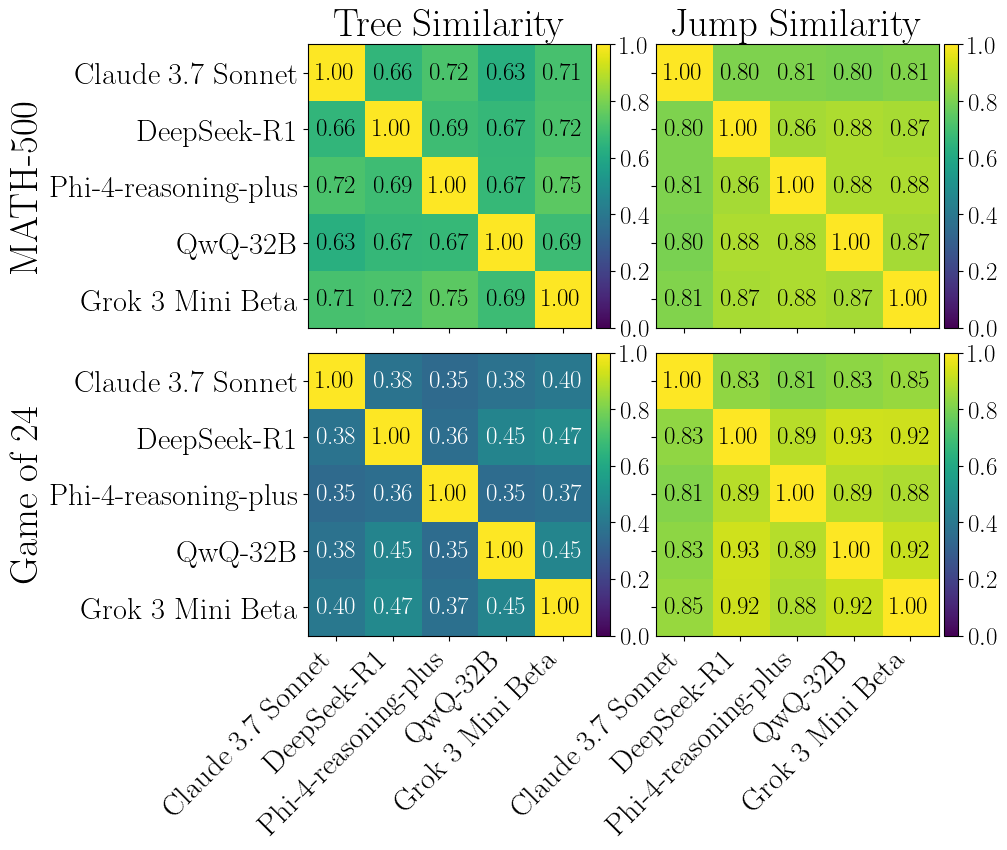

In [9]:
# Create a figure with 4 subplots (2x2 grid) for the heatmaps
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(left=0.3, bottom=.13, right=0.95, top=1.05, wspace=0.15, hspace=-0.35)
fig.set_size_inches(10, 8.5)

# Define the metrics and datasets for the subplots
similarity_metrics = ["tree", "jump"]
datasets_list = list(final_datasets.keys())

# Create a mapping for model names to indices for the heatmap
model_names = sorted(list(set([m for pair in model_pairs for m in pair])))
model_indices = {model: i for i, model in enumerate(model_names)}
model_labels = [models[model]["label"] for model in model_names]

# Create the heatmaps
for dataset_idx, dataset in enumerate(datasets_list[:2]):  # Using first two datasets
    for metric_idx, metric in enumerate(similarity_metrics):
        # Calculate subplot index
        subplot_idx = dataset_idx * 2 + metric_idx
        current_ax = axs[dataset_idx, metric_idx]
        
        # Create empty similarity matrix
        sim_matrix = np.zeros((len(model_names), len(model_names)))
        
        # Fill diagonal with 1.0 (self-similarity)
        np.fill_diagonal(sim_matrix, 1.0)
        
        # Fill the matrix with similarity values
        for model1, model2 in model_pairs:
            i, j = model_indices[model1], model_indices[model2]
            # Get similarity value, defaulting to NaN if not found
            sim_value = similarities[metric].get((model1, model2, dataset), 
                                               similarities[metric].get((model2, model1, dataset), np.nan))
            sim_matrix[i, j] = sim_value
            sim_matrix[j, i] = sim_value  # Symmetrical matrix
        
        # Create heatmap
        im = current_ax.imshow(sim_matrix, cmap='viridis', vmin=0, vmax=1)
        
        # Add colorbar with the same height as the heatmap

        divider = make_axes_locatable(current_ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        # cbar.set_label(f'{metric.capitalize()} Similarity')
        
        # Make the colorbar tick labels smaller
        cbar.ax.tick_params(labelsize=18)
        
        # Set title and labels
        # current_ax.set_title(f"{final_datasets[dataset]} - {metric.capitalize()} Similarity")
        current_ax.set_xticks(np.arange(len(model_names)))
        current_ax.set_yticks(np.arange(len(model_names)))
        current_ax.set_xticklabels(model_labels, rotation=45, ha="right",fontsize=22)
        current_ax.set_yticklabels(model_labels,fontsize=22)
        
        # Add text annotations in the heatmap cells
        for i in range(len(model_names)):
            for j in range(len(model_names)):
                text_color = "white" if sim_matrix[i, j] < 0.5 else "black"
                current_ax.text(j, i, f"{sim_matrix[i, j]:.2f}", 
                                     ha="center", va="center", color=text_color, fontsize=18)

# Add y-axis labels for each row (dataset name)
for dataset_idx, dataset in enumerate(datasets_list[:2]):
    # Add label to the first subplot of each row
    axs[dataset_idx, 0].set_ylabel(final_datasets[dataset], fontsize=28, fontweight='bold')

# Add x-axis labels at the top for each column (metric name)
for metric_idx, metric in enumerate(similarity_metrics):
    # Add label to the top subplot of each column
    axs[0, metric_idx].set_title(f"{metric.capitalize()} Similarity", fontsize=28, fontweight='bold')

plt.savefig(f"{root_dir}/figures/benchmark_similarities_temp1.pdf")
plt.show()


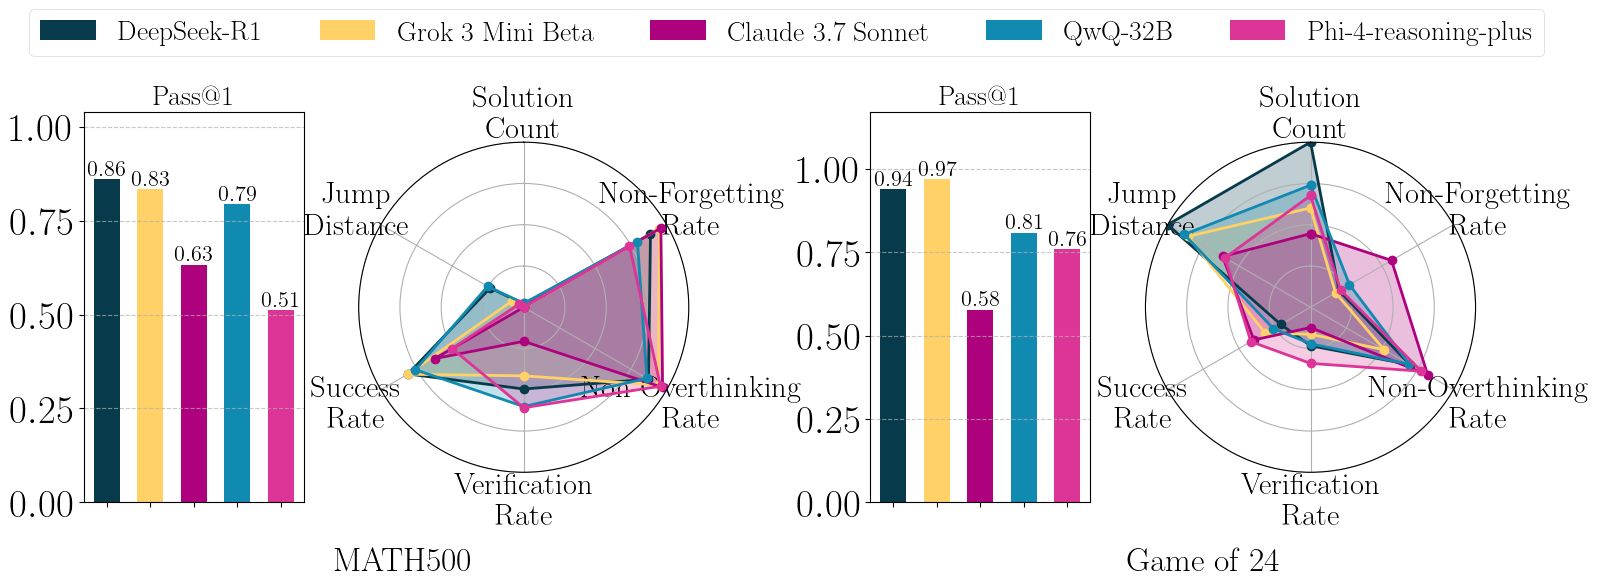

In [18]:
this_metrics = [
    "average_correlation",  # Put average_correlation first
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "overall_average_verification_rate",
    "average_overthinking_rate",
    "average_forgetting_rate",
]

# fig, axs = plt.subplots(1, 4, figsize=(20, 6), gridspec_kw={'width_ratios': [4, 6, 4, 6]})

# ADD THIS BLOCK TO REPLACE THE LINE ABOVE

# 1. Create the main figure
fig = plt.figure(figsize=(16, 6))

# 2. Create the main 1x2 GridSpec with the LARGE spacing between plot pairs
# This creates the big gap between the 2nd and 3rd plots.
gs_main = fig.add_gridspec(1, 2, wspace=0.3) 

# 3. Create a nested GridSpec for the left pair of plots (wspace=0.1)
gs_left = gs_main[0].subgridspec(1, 2, wspace=0.2, width_ratios=[4, 6])

# 4. Create a nested GridSpec for the right pair of plots (wspace=0.1)
gs_right = gs_main[1].subgridspec(1, 2, wspace=0.2, width_ratios=[4, 6])

# 5. Create the axes and put them in a list for your loop
axs = [
    fig.add_subplot(gs_left[0]),
    fig.add_subplot(gs_left[1]),
    fig.add_subplot(gs_right[0]),
    fig.add_subplot(gs_right[1]),
]

fig.subplots_adjust(left=0.05, bottom=0.15, right=0.92, top=0.8, hspace=0.3)

# Add titles for the left and right plot pairs
fig.text(0.25, 0.05, 'MATH500', ha='center', va='center', fontsize=24, fontweight='bold')
fig.text(0.75, 0.05, 'Game of 24', ha='center', va='center', fontsize=24, fontweight='bold')

# Process both datasets
datasets_to_plot = ["math500", "game24"]

# Pre-normalize radar metrics across both datasets
radar_metrics = this_metrics[1:]  # Skip average_correlation
global_normalized_data = {}

# Metrics that need normalization
metrics_to_normalize = ["average_solution_count", "filtered_ajd"]

for metric in radar_metrics:
    global_normalized_data[metric] = {}
    
    if metric in metrics_to_normalize:
        # Get all values for this metric across all models and datasets for normalization
        all_values = []
        for dataset_key in datasets_to_plot:
            for model in models:
                original_value = reasoning_metrics[dataset_key][metric][model]
                all_values.append(original_value)
        
        min_val = min(all_values)
        max_val = max(all_values)
        
        # Normalize to 0-1 range across both datasets
        for dataset_key in datasets_to_plot:
            global_normalized_data[metric][dataset_key] = {}
            for model in models:
                original_value = reasoning_metrics[dataset_key][metric][model]
                if max_val == min_val:
                    normalized_value = 0.5  # If all values are the same, set to middle
                else:
                    normalized_value = (original_value - min_val) / (max_val - min_val)
                global_normalized_data[metric][dataset_key][model] = normalized_value
    else:
        # For metrics that don't need normalization, just use original values
        for dataset_key in datasets_to_plot:
            global_normalized_data[metric][dataset_key] = {}
            for model in models:
                original_value = reasoning_metrics[dataset_key][metric][model]
                # Take inverse for overthinking and forgetting rates
                if metric in ["average_overthinking_rate", "average_forgetting_rate"]:
                    original_value = 1 - original_value
                global_normalized_data[metric][dataset_key][model] = original_value

for col_pair, dataset_key in enumerate(datasets_to_plot):
    dataset_name = final_datasets[dataset_key]
    bar_col = col_pair * 2
    radar_col = col_pair * 2 + 1
    
    # First subplot: Bar plot for average_correlation (pass@1)
    metric = "average_correlation"
    axs[bar_col].set_title(f"{metrics[metric]['label']}", fontsize=20, fontweight='bold')

    # Plot bars for each model
    bar_width = 0.6
    model_positions = np.arange(len(models))
    for j, model in enumerate(models):
        value = reasoning_metrics[dataset_key][metric][model]
        axs[bar_col].bar(j, value, bar_width, 
                  label=models[model]["label"], 
                  color=models[model]["color"])
        # Add value labels on top of bars
        axs[bar_col].text(j, value, f'{value:.2f}', ha='center', va='bottom', fontsize=16)

    axs[bar_col].set_xticks(model_positions)
    axs[bar_col].set_xticklabels([])  # Remove x-axis labels
    axs[bar_col].grid(axis='y', linestyle='--', alpha=0.7)
    current_ylim = axs[bar_col].get_ylim()
    axs[bar_col].set_ylim(0, current_ylim[1] * 1.15)
    
    # Add legend only to the first subplot
    if col_pair == 0:
        axs[bar_col].legend(loc='upper right', fontsize=20, ncol=5, bbox_to_anchor=(6.7, 1.3))

    # Turn off the regular subplot for radar plot
    axs[radar_col].axis('off')
    
    # --- START: CORRECTED CODE ---

    # Turn off the axis of the placeholder subplot
    axs[radar_col].axis('off')

    # Determine the correct GridSpec slicer based on the loop iteration
    if col_pair == 0:
        # This is the first pair of plots, use the second cell of the left GridSpec
        gs_slicer = gs_left[1]
    else:
        # This is the second pair, use the second cell of the right GridSpec
        gs_slicer = gs_right[1]

    # Create the new polar axes in the correct, specific location
    ax_radar = fig.add_subplot(gs_slicer, projection='polar')

    # --- END: CORRECTED CODE ---

    # Create 6 equally spaced angles for hexagon
    angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the hexagon

    # Plot each model using globally normalized data
    for model in models:
        values = []
        for metric in radar_metrics:
            values.append(global_normalized_data[metric][dataset_key][model])
        
        # Complete the hexagon
        values += values[:1]
        
        # Plot the line and fill
        ax_radar.plot(angles, values, 'o-', linewidth=2, 
                     label=models[model]["label"], color=models[model]["color"])
        ax_radar.fill(angles, values, alpha=0.25, color=models[model]["color"])

    # Customize the radar plot to be hexagonal
    ax_radar.set_xticks(angles[:-1])
    # Create labels with 1-original for overthinking and forgetting rates
    radar_labels = []
    for metric in radar_metrics:
        if metric in ["average_overthinking_rate", "average_forgetting_rate"]:
            label = metrics[metric]['plain_label'].replace(' ', '\n')
            radar_labels.append(f"Non-{label}")
        elif metric in ["average_solution_count", "filtered_ajd"]:
            plain_label = metrics[metric]["plain_label"].replace(" ", "\n")
            radar_labels.append(plain_label)
        else:
            radar_labels.append(metrics[metric]["plain_label"].replace(" ", "\n"))
    ax_radar.set_xticklabels(radar_labels, fontsize=22)
    ax_radar.set_ylim(0, 1)
    ax_radar.set_yticklabels([])  # <-- ADD THIS LINE
    ax_radar.grid(True)

    # Make the plot hexagonal by setting theta direction and zero location
    ax_radar.set_theta_direction(1)
    ax_radar.set_theta_zero_location('N')

    # Adjust label distance to prevent overlap with the radar plot
    ax_radar.tick_params(axis='x', pad=10)

    # Add title to radar plot
    # ax_radar.set_title(f"{dataset_name} - Other Metrics", fontsize=18, fontweight='bold', pad=20)

plt.savefig(f"{root_dir}/figures/benchmark_temp1_radar.pdf")


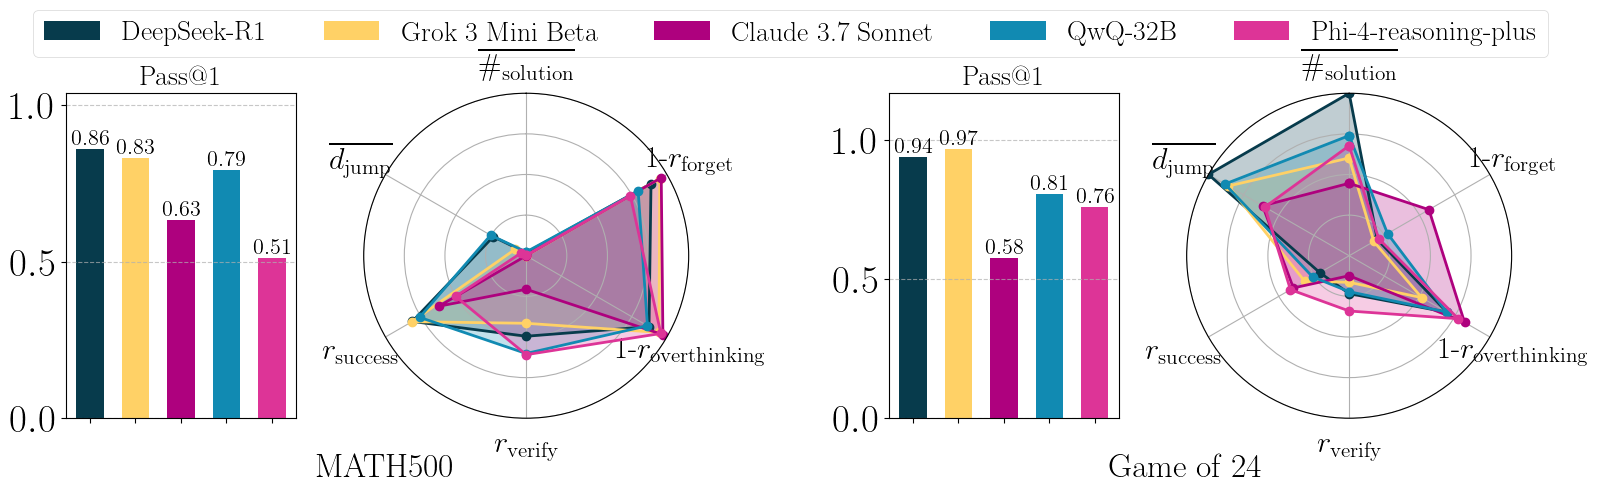

In [11]:
this_metrics = [
    "average_correlation",  # Put average_correlation first
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "overall_average_verification_rate",
    "average_overthinking_rate",
    "average_forgetting_rate",
]

# fig, axs = plt.subplots(1, 4, figsize=(20, 6), gridspec_kw={'width_ratios': [4, 6, 4, 6]})

# ADD THIS BLOCK TO REPLACE THE LINE ABOVE

# 1. Create the main figure
fig = plt.figure(figsize=(16, 5))

# 2. Create the main 1x2 GridSpec with the LARGE spacing between plot pairs
# This creates the big gap between the 2nd and 3rd plots.
gs_main = fig.add_gridspec(1, 2, wspace=0.3) 

# 3. Create a nested GridSpec for the left pair of plots (wspace=0.1)
gs_left = gs_main[0].subgridspec(1, 2, wspace=0.2, width_ratios=[4, 6])

# 4. Create a nested GridSpec for the right pair of plots (wspace=0.1)
gs_right = gs_main[1].subgridspec(1, 2, wspace=0.2, width_ratios=[4, 6])

# 5. Create the axes and put them in a list for your loop
axs = [
    fig.add_subplot(gs_left[0]),
    fig.add_subplot(gs_left[1]),
    fig.add_subplot(gs_right[0]),
    fig.add_subplot(gs_right[1]),
]

fig.subplots_adjust(left=0.05, bottom=0.15, right=0.96, top=0.8, hspace=0.3)

# Add titles for the left and right plot pairs
fig.text(0.25, 0.05, 'MATH500', ha='center', va='center', fontsize=24, fontweight='bold')
fig.text(0.75, 0.05, 'Game of 24', ha='center', va='center', fontsize=24, fontweight='bold')

# Process both datasets
datasets_to_plot = ["math500", "game24"]

# Pre-normalize radar metrics across both datasets
radar_metrics = this_metrics[1:]  # Skip average_correlation
global_normalized_data = {}

# Metrics that need normalization
metrics_to_normalize = ["average_solution_count", "filtered_ajd"]

for metric in radar_metrics:
    global_normalized_data[metric] = {}
    
    if metric in metrics_to_normalize:
        # Get all values for this metric across all models and datasets for normalization
        all_values = []
        for dataset_key in datasets_to_plot:
            for model in models:
                original_value = reasoning_metrics[dataset_key][metric][model]
                all_values.append(original_value)
        
        min_val = min(all_values)
        max_val = max(all_values)
        
        # Normalize to 0-1 range across both datasets
        for dataset_key in datasets_to_plot:
            global_normalized_data[metric][dataset_key] = {}
            for model in models:
                original_value = reasoning_metrics[dataset_key][metric][model]
                if max_val == min_val:
                    normalized_value = 0.5  # If all values are the same, set to middle
                else:
                    normalized_value = (original_value - min_val) / (max_val - min_val)
                global_normalized_data[metric][dataset_key][model] = normalized_value
    else:
        # For metrics that don't need normalization, just use original values
        for dataset_key in datasets_to_plot:
            global_normalized_data[metric][dataset_key] = {}
            for model in models:
                original_value = reasoning_metrics[dataset_key][metric][model]
                # Take inverse for overthinking and forgetting rates
                if metric in ["average_overthinking_rate", "average_forgetting_rate"]:
                    original_value = 1 - original_value
                global_normalized_data[metric][dataset_key][model] = original_value

for col_pair, dataset_key in enumerate(datasets_to_plot):
    dataset_name = final_datasets[dataset_key]
    bar_col = col_pair * 2
    radar_col = col_pair * 2 + 1
    
    # First subplot: Bar plot for average_correlation (pass@1)
    metric = "average_correlation"
    axs[bar_col].set_title(f"{metrics[metric]['label']}", fontsize=20, fontweight='bold')

    # Plot bars for each model
    bar_width = 0.6
    model_positions = np.arange(len(models))
    for j, model in enumerate(models):
        value = reasoning_metrics[dataset_key][metric][model]
        axs[bar_col].bar(j, value, bar_width, 
                  label=models[model]["label"], 
                  color=models[model]["color"])
        # Add value labels on top of bars
        axs[bar_col].text(j, value, f'{value:.2f}', ha='center', va='bottom', fontsize=16)

    axs[bar_col].set_xticks(model_positions)
    axs[bar_col].set_xticklabels([])  # Remove x-axis labels
    axs[bar_col].grid(axis='y', linestyle='--', alpha=0.7)
    current_ylim = axs[bar_col].get_ylim()
    axs[bar_col].set_ylim(0, current_ylim[1] * 1.15)
    
    # Add legend only to the first subplot
    if col_pair == 0:
        axs[bar_col].legend(loc='upper right', fontsize=20, ncol=5, bbox_to_anchor=(6.5, 1.3))

    # Turn off the regular subplot for radar plot
    axs[radar_col].axis('off')
    
    # --- START: CORRECTED CODE ---

    # Turn off the axis of the placeholder subplot
    axs[radar_col].axis('off')

    # Determine the correct GridSpec slicer based on the loop iteration
    if col_pair == 0:
        # This is the first pair of plots, use the second cell of the left GridSpec
        gs_slicer = gs_left[1]
    else:
        # This is the second pair, use the second cell of the right GridSpec
        gs_slicer = gs_right[1]

    # Create the new polar axes in the correct, specific location
    ax_radar = fig.add_subplot(gs_slicer, projection='polar')

    # --- END: CORRECTED CODE ---

    # Create 6 equally spaced angles for hexagon
    angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the hexagon

    # Plot each model using globally normalized data
    for model in models:
        values = []
        for metric in radar_metrics:
            values.append(global_normalized_data[metric][dataset_key][model])
        
        # Complete the hexagon
        values += values[:1]
        
        # Plot the line and fill
        ax_radar.plot(angles, values, 'o-', linewidth=2, 
                     label=models[model]["label"], color=models[model]["color"])
        ax_radar.fill(angles, values, alpha=0.25, color=models[model]["color"])

    # Customize the radar plot to be hexagonal
    ax_radar.set_xticks(angles[:-1])
    # Create labels with 1-original for overthinking and forgetting rates
    radar_labels = []
    for metric in radar_metrics:
        if metric in ["average_overthinking_rate", "average_forgetting_rate"]:
            radar_labels.append(f"1-{metrics[metric]['concise_label']}")
        elif metric in ["average_solution_count", "filtered_ajd"]:
            concise_label = metrics[metric]["concise_label"].replace("$", "")
            radar_labels.append(f"$\\overline{{{concise_label}}}$")
        else:
            radar_labels.append(metrics[metric]["concise_label"])
    ax_radar.set_xticklabels(radar_labels, fontsize=22)
    ax_radar.set_ylim(0, 1)
    ax_radar.set_yticklabels([])  # <-- ADD THIS LINE
    ax_radar.grid(True)

    # Make the plot hexagonal by setting theta direction and zero location
    ax_radar.set_theta_direction(1)
    ax_radar.set_theta_zero_location('N')

    # Adjust label distance to prevent overlap with the radar plot
    ax_radar.tick_params(axis='x', pad=10)

    # Add title to radar plot
    # ax_radar.set_title(f"{dataset_name} - Other Metrics", fontsize=18, fontweight='bold', pad=20)

plt.savefig(f"{root_dir}/figures/benchmark_temp1_radar.pdf")


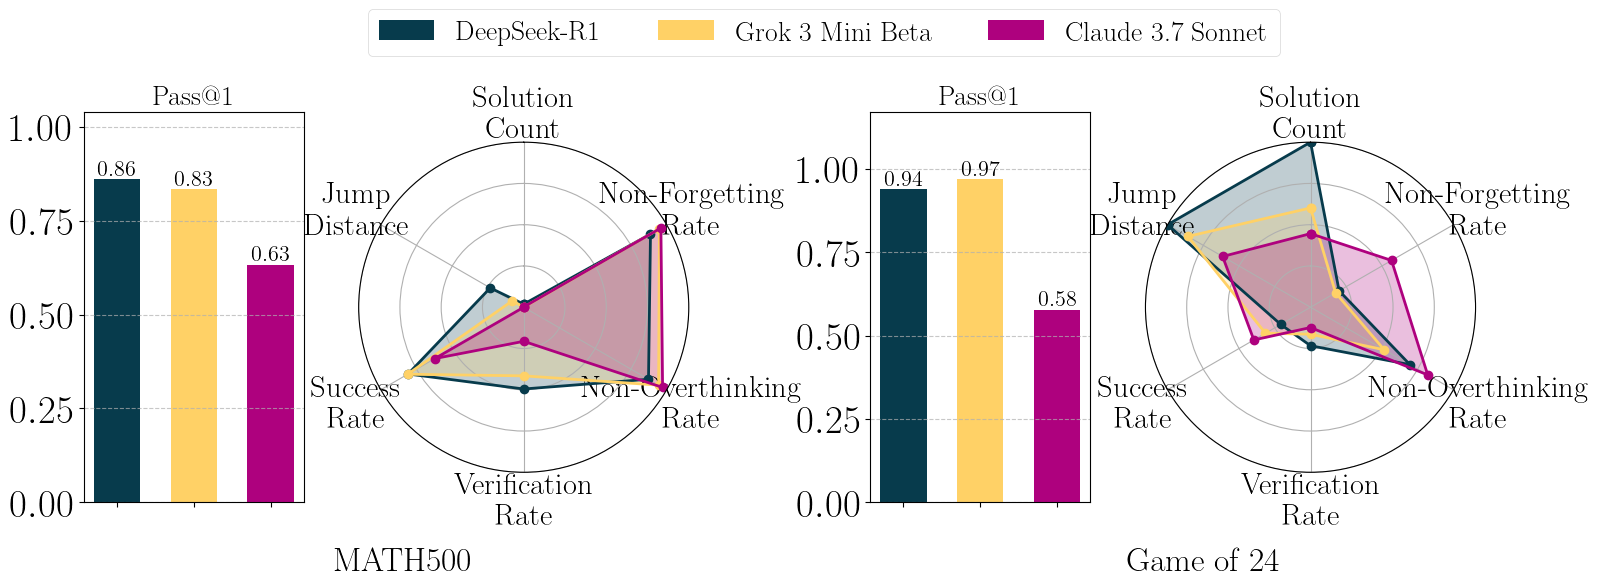

In [14]:
this_metrics = [
    "average_correlation",  # Put average_correlation first
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "overall_average_verification_rate",
    "average_overthinking_rate",
    "average_forgetting_rate",
]

# Only consider the first three models
first_three_model_keys = list(models.keys())[:3]

# 1. Create the main figure
fig = plt.figure(figsize=(16, 6))

# 2. Create the main 1x2 GridSpec with the LARGE spacing between plot pairs
gs_main = fig.add_gridspec(1, 2, wspace=0.3) 

# 3. Create a nested GridSpec for the left pair of plots (wspace=0.1)
gs_left = gs_main[0].subgridspec(1, 2, wspace=0.2, width_ratios=[4, 6])

# 4. Create a nested GridSpec for the right pair of plots (wspace=0.1)
gs_right = gs_main[1].subgridspec(1, 2, wspace=0.2, width_ratios=[4, 6])

# 5. Create the axes and put them in a list for your loop
axs = [
    fig.add_subplot(gs_left[0]),
    fig.add_subplot(gs_left[1]),
    fig.add_subplot(gs_right[0]),
    fig.add_subplot(gs_right[1]),
]

fig.subplots_adjust(left=0.05, bottom=0.15, right=0.92, top=0.8, hspace=0.3)

# Add titles for the left and right plot pairs
fig.text(0.25, 0.05, 'MATH500', ha='center', va='center', fontsize=24, fontweight='bold')
fig.text(0.75, 0.05, 'Game of 24', ha='center', va='center', fontsize=24, fontweight='bold')

# Process both datasets
datasets_to_plot = ["math500", "game24"]

# Pre-normalize radar metrics across both datasets
radar_metrics = this_metrics[1:]  # Skip average_correlation
global_normalized_data = {}

# Metrics that need normalization
metrics_to_normalize = ["average_solution_count", "filtered_ajd"]

for metric in radar_metrics:
    global_normalized_data[metric] = {}
    
    if metric in metrics_to_normalize:
        # Get all values for this metric across all models and datasets for normalization
        all_values = []
        for dataset_key in datasets_to_plot:
            for model in first_three_model_keys:
                original_value = reasoning_metrics[dataset_key][metric][model]
                all_values.append(original_value)
        
        min_val = min(all_values)
        max_val = max(all_values)
        
        # Normalize to 0-1 range across both datasets
        for dataset_key in datasets_to_plot:
            global_normalized_data[metric][dataset_key] = {}
            for model in first_three_model_keys:
                original_value = reasoning_metrics[dataset_key][metric][model]
                if max_val == min_val:
                    normalized_value = 0.5  # If all values are the same, set to middle
                else:
                    normalized_value = (original_value - min_val) / (max_val - min_val)
                global_normalized_data[metric][dataset_key][model] = normalized_value
    else:
        # For metrics that don't need normalization, just use original values
        for dataset_key in datasets_to_plot:
            global_normalized_data[metric][dataset_key] = {}
            for model in first_three_model_keys:
                original_value = reasoning_metrics[dataset_key][metric][model]
                # Take inverse for overthinking and forgetting rates
                if metric in ["average_overthinking_rate", "average_forgetting_rate"]:
                    original_value = 1 - original_value
                global_normalized_data[metric][dataset_key][model] = original_value

for col_pair, dataset_key in enumerate(datasets_to_plot):
    dataset_name = final_datasets[dataset_key]
    bar_col = col_pair * 2
    radar_col = col_pair * 2 + 1
    
    # First subplot: Bar plot for average_correlation (pass@1)
    metric = "average_correlation"
    axs[bar_col].set_title(f"{metrics[metric]['label']}", fontsize=20, fontweight='bold')

    # Plot bars for each of the first three models
    bar_width = 0.6
    model_positions = np.arange(len(first_three_model_keys))
    for j, model in enumerate(first_three_model_keys):
        value = reasoning_metrics[dataset_key][metric][model]
        axs[bar_col].bar(j, value, bar_width, 
                  label=models[model]["label"], 
                  color=models[model]["color"])
        # Add value labels on top of bars
        axs[bar_col].text(j, value, f'{value:.2f}', ha='center', va='bottom', fontsize=16)

    axs[bar_col].set_xticks(model_positions)
    axs[bar_col].set_xticklabels([])  # Remove x-axis labels
    axs[bar_col].grid(axis='y', linestyle='--', alpha=0.7)
    current_ylim = axs[bar_col].get_ylim()
    axs[bar_col].set_ylim(0, current_ylim[1] * 1.15)
    
    # Add legend only to the first subplot
    if col_pair == 0:
        axs[bar_col].legend(loc='upper right', fontsize=20, ncol=5, bbox_to_anchor=(5.5, 1.3))

    # Turn off the regular subplot for radar plot
    axs[radar_col].axis('off')
    
    # --- START: CORRECTED CODE ---

    # Turn off the axis of the placeholder subplot
    axs[radar_col].axis('off')

    # Determine the correct GridSpec slicer based on the loop iteration
    if col_pair == 0:
        # This is the first pair of plots, use the second cell of the left GridSpec
        gs_slicer = gs_left[1]
    else:
        # This is the second pair, use the second cell of the right GridSpec
        gs_slicer = gs_right[1]

    # Create the new polar axes in the correct, specific location
    ax_radar = fig.add_subplot(gs_slicer, projection='polar')

    # --- END: CORRECTED CODE ---

    # Create 6 equally spaced angles for hexagon
    angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the hexagon

    # Plot each model using globally normalized data (only first three models)
    for model in first_three_model_keys:
        values = []
        for metric in radar_metrics:
            values.append(global_normalized_data[metric][dataset_key][model])
        
        # Complete the hexagon
        values += values[:1]
        
        # Plot the line and fill
        ax_radar.plot(angles, values, 'o-', linewidth=2, 
                     label=models[model]["label"], color=models[model]["color"])
        ax_radar.fill(angles, values, alpha=0.25, color=models[model]["color"])

    # Customize the radar plot to be hexagonal
    ax_radar.set_xticks(angles[:-1])
    # Create labels with 1-original for overthinking and forgetting rates
    radar_labels = []
    for metric in radar_metrics:
        if metric in ["average_overthinking_rate", "average_forgetting_rate"]:
            label = metrics[metric]['plain_label'].replace(' ', '\n')
            radar_labels.append(f"Non-{label}")
        elif metric in ["average_solution_count", "filtered_ajd"]:
            plain_label = metrics[metric]["plain_label"].replace(" ", "\n")
            radar_labels.append(plain_label)
        else:
            radar_labels.append(metrics[metric]["plain_label"].replace(" ", "\n"))
    ax_radar.set_xticklabels(radar_labels, fontsize=22)
    ax_radar.set_ylim(0, 1)
    ax_radar.set_yticklabels([])  # <-- ADD THIS LINE
    ax_radar.grid(True)

    # Make the plot hexagonal by setting theta direction and zero location
    ax_radar.set_theta_direction(1)
    ax_radar.set_theta_zero_location('N')

    # Adjust label distance to prevent overlap with the radar plot
    ax_radar.tick_params(axis='x', pad=10)

    # Add title to radar plot
    # ax_radar.set_title(f"{dataset_name} - Other Metrics", fontsize=18, fontweight='bold', pad=20)

plt.savefig(f"{root_dir}/figures/benchmark_temp1_radar_top3.pdf")
